# Spec2Vec - library matching
One very important use case for a spectral similariy measure is libarary matching.  
This means matching previously unseen/unknown spectra to known, annotated sepctra in a larger library.

In [1]:
# Locations
ROOT = "C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA"
PATH_SPEC2VEC = ROOT + "\\Spec2Vec\\code\\"
PATH_MS_DATA = ROOT + "\\Data\\GNPS_all\\"
PATH_SAVE_MODEL = ROOT + "\\Spec2Vec\\models_trained\\"
PATH_COMPUTED = ROOT + "\\Spec2Vec\\computed_results\\"
PATH_OUTPUT = ROOT + "\\Spec2Vec\\output_plots\\"

In [2]:
import numpy as np
import sys
sys.path.insert(0, PATH_SPEC2VEC)

In [3]:
import helper_functions as functions
import MS_functions
import MS_similarity_classical as MS_sim_classic
from similarity_measure import SimilarityMeasures
from plotting_functions import plot_precentile

from scipy import spatial

### Load filtered allGNPS_positive dataset OR:  Import& filter allGNPS_positive dataset

In [4]:
file_json = PATH_MS_DATA + "allGNPS_positive_minmax_10_1000_2dec_exp08_191115.json"
file_mgf = ROOT + "\\Data\\GNPS_all\\" + "allGNPS_positive_191106.mgf"

spectra, spectra_dict, MS_documents, MS_documents_intensity, spectra_metadata = MS_functions.load_MGF_data(file_mgf = file_mgf,
                                                           file_json = file_json,
                                                           num_decimals = 2,
                                                           min_frag = 0.0, max_frag = 1000.0,
                                                           min_loss = 5.0, max_loss = 500.0,
                                                           min_intensity_perc = 0,
                                                           exp_intensity_filter = 0.8,
                                                           min_keep_peaks_0 = 10,
                                                           min_keep_peaks_per_mz = 20/200,
                                                           min_peaks = 10,
                                                           max_peaks = 1000,
                                                           peak_loss_words = ['peak_', 'loss_'])

Spectra json file found and loaded.


In [5]:
spectra_metadata.head()

,doc_ID,gnps_ID,name,title,precursor_mz,num_peaks_losses,inchi,inchikey,smiles,charge
0,0,CCMSLIB00005435503,chenodeoxycholic acid M-H2O+H,NaN,375.290,93,"""InChI=1S/C24H40O4/c1-14(4-7-21(27)28)17-5-6-1...",RUDATBOHQWOJDD-GYHJSIKNSA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,1
1,1,CCMSLIB00005435504,chenodeoxycholic acid 2M+H,NaN,785.593,101,"""InChI=1S/C24H40O4/c1-14(4-7-21(27)28)17-5-6-1...",RUDATBOHQWOJDD-PODLAYBOSA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,1
2,2,CCMSLIB00005435505,chenodeoxycholic acid 2M+Na,NaN,807.575,21,"""InChI=1S/C24H40O4/c1-14(4-7-21(27)28)17-5-6-1...",RUDATBOHQWOJDD-PODLAYBOSA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,1
3,3,CCMSLIB00005435506,cholic acid M+Na,NaN,431.277,35,"""InChI=1S/C24H40O5/c1-13(4-7-21(28)29)16-5-6-1...",BHQCQFFYRZLCQQ-IHELEQLESA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1([C@H](C[...,1
4,4,CCMSLIB00005435507,deoxycholic acid M-H2O+H,NaN,375.289,157,"""InChI=1S/C24H40O4/c1-14(4-9-22(27)28)18-7-8-1...",KXGVEGMKQFWNSR-BKAWJTANSA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1([C@H](C[...,1


### Evaluate inchikey occurences

In [29]:
inchikeys_pd = spectra_metadata['inchikey'][spectra_metadata['inchikey'].notnull()]
inchikeys_pd.shape

(50195,)

In [139]:
inchikeys_pd.str[:14][-10:]

90216    CCQDWIRWKWIUKK
90217    RPVIQWDFJPYNJM
90218    BXEZTCOKOLHMKY
90219    BXEZTCOKOLHMKY
90220    PVXPPJIGRGXGCY
90221    ATEFPOUAMCWAQS
90222    ILEDWLMCKZNDJK
90223    ILEDWLMCKZNDJK
90224    NCJNNMWJQIKYLO
90225    LNCLTICCQWMCNS
Name: inchikey, dtype: object

### Get inchikey (first 14 letters) occurences

In [64]:
inchikeys_pd.str[:14].value_counts()[:10]

PFTAWBLQPZVEMU    63
KMPWYEUPVWOPIM    57
MPDGHEJMBKOTSU    49
TZBJGXHYKVUXJN    46
DFPMSGMNTNDNHN    46
RYYVLZVUVIJVGH    45
LJOQGZACKSYWCH    45
OXGUCUVFOIWWQJ    45
LOUPRKONTZGTKE    43
HPNSFSBZBAHARI    43
Name: inchikey, dtype: int64

### Plot histogram of inchikey occurences

Text(0, 0.5, 'Number of inchikeys with respective number of occurences')

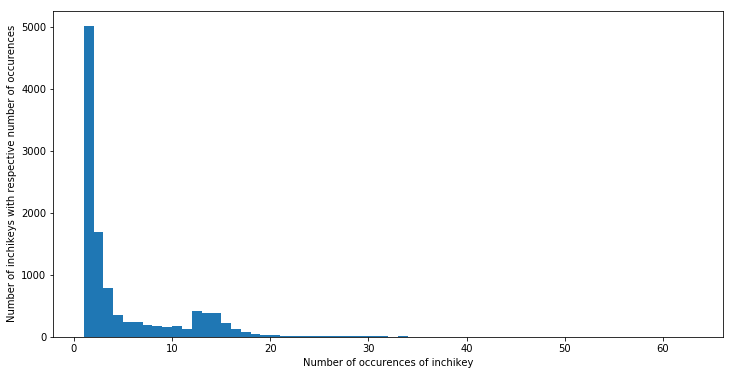

In [67]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,6))
plt.hist(inchikeys_pd.str[:14].value_counts(), 62)
plt.xlabel('Number of occurences of inchikey')
plt.ylabel('Number of inchikeys with respective number of occurences')

## Select spectra to simulate libarary matching

In [83]:
suitable_inchikeys = inchikeys_pd.str[:14].value_counts()[inchikeys_pd.str[:14].value_counts().values > 1]
suitable_inchikeys.tail()

FRNDILDQFSAXAR    2
HPSWAEGGWLOOKT    2
JCHUCLMYSKXMOY    2
RYBXJAJHOPCXHS    2
DNTDOBSIBZKFCP    2
Name: inchikey, dtype: int64

In [99]:
print("Number of spectra with inchikeys that exist >1 times:", suitable_inchikeys.shape[0])

Number of spectra with inchikeys that exist >1 times: 5998


### Randomly select 500 inchikeys that exist >1 times in the dataset

In [97]:
num_spectra = 500

np.random.seed(42) # to make it reproducible
selection = np.random.choice(suitable_inchikeys.shape[0], num_spectra, replace=False)
selected_inchikeys = suitable_inchikeys.index.values[selection]
selected_inchikeys

array(['WUADCCWRTIWANL', 'SLSIBLKBHNKZTB', 'QFZISQBFEIXWDM',
       'RONZAEMNMFQXRA', 'YFGYUFNIOHWBOB', 'DFFWZNDCNBOKDI',
       'HVHUQDDJNAABOF', 'JEQWQKAKFXGXKA', 'SVVDSOGSSNNTFJ',
       'QDEYKGKBMCIYCT', 'SRPHMISUTWFFKJ', 'CFJLERBDXYGARW',
       'ZCKITOSCNKNMMO', 'FCLRMHVOEFMMCX', 'HHJTWTPUPVQKNA',
       'PPWHTZKZQNXVAE', 'FOYHNROGBXVLLX', 'SATIISJKSAELDC',
       'VEVZSMAEJFVWIL', 'ACWBBAGYTKWBCD', 'JHAXQRDTTACRKJ',
       'QIUYUYOXCGBABP', 'QHMTXANCGGJZRX', 'ZJMZZNVGNSWOOM',
       'KHWHODOWEXOYIJ', 'FOJARNPMBSAHNV', 'CTTHWASMBLQOFR',
       'OKBWVJGQTFYYQA', 'ULGZDMOVFRHVEP', 'COCNDHOPIHDTHK',
       'WYEMLYFITZORAB', 'DPXWHZUTDZONDB', 'CNEWEMXPRRKCTL',
       'YJRLSCDUYLRBIZ', 'ICMGLRUYEQNHPF', 'HCJXEOFLVIFFDG',
       'TUGAUFMQYWZJAB', 'WRXVPTMENPZUIZ', 'VLGUKBMOYDQZNE',
       'VQHYUBJDKHMCEY', 'SEBIKDIMAPSUBY', 'OXKMZIABKYHLAR',
       'YDOTUXAWKBPQJW', 'XBLHNZRXAORYAC', 'VKYKSIONXSXAKP',
       'ZONXEWIGPLHXNT', 'KFEUJDWYNGMDBV', 'NFINSJKQOBJWEB',
       'MDMCODCJMHTFIZ',

In [101]:
suitable_inchikeys[selection].value_counts()

2     135
3      62
12     38
4      32
13     30
14     30
6      21
5      19
15     19
8      17
10     16
16     13
7      12
9      11
11     11
17      7
18      6
20      4
26      3
19      2
41      2
40      1
22      1
23      1
24      1
25      1
28      1
29      1
31      1
33      1
34      1
Name: inchikey, dtype: int64

### Randomly pick one spectra for each of the chosen inchikeys

In [155]:
selected_spectra = []

np.random.seed(42) # to make it reproducible
for inchikey in selected_inchikeys:
    matches = inchikeys_pd[inchikeys_pd.str[:14] == inchikey].index.values
    selected_spectra.append(int(np.random.choice(matches,1)[0]))

In [160]:
# Show gnps IDs for selected spectra
spectra_metadata["gnps_ID"][selected_spectra]

24243    CCMSLIB00000205651
23687    CCMSLIB00000204756
9034     CCMSLIB00000847642
33806    CCMSLIB00000568985
26281    CCMSLIB00000210444
25033    CCMSLIB00000207076
3892     CCMSLIB00000478551
12170    CCMSLIB00000853571
27736    CCMSLIB00000215049
56096    CCMSLIB00004717755
13427    CCMSLIB00000856142
54927    CCMSLIB00004716202
49914    CCMSLIB00004709935
3629     CCMSLIB00000424996
32835    CCMSLIB00000567362
14733    CCMSLIB00000086026
28632    CCMSLIB00000217859
4161     CCMSLIB00000579202
34976    CCMSLIB00004684723
30653    CCMSLIB00000223246
10981    CCMSLIB00000850979
10294    CCMSLIB00000848990
929      CCMSLIB00001058413
25870    CCMSLIB00000208841
8590     CCMSLIB00000846925
32072    CCMSLIB00000563347
32322    CCMSLIB00000566366
47912    CCMSLIB00004707432
22444    CCMSLIB00000078218
29309    CCMSLIB00000219482
                ...        
48274    CCMSLIB00004707884
11825    CCMSLIB00000852872
23590    CCMSLIB00000427244
25706    CCMSLIB00000208463
13062    CCMSLIB0000

In [158]:
max(selected_spectra), len(selected_spectra)

(89910, 500)

## Train new Spec2Vec model on dataset without the selected spectra

In [161]:
# Remove selected spectra from corpus
MS_documents_removedpart = [MS_documents[x] for x in range(len(MS_documents)) if x not in selected_spectra]   
print("Modified corpus consists of", len(MS_documents_removedpart), "documents.")

MS_measure = SimilarityMeasures(MS_documents_removedpart)
MS_measure.preprocess_documents(1, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_measure.dictionary))

# Train new model based on reduced corpus
file_model_word2vec = PATH_SAVE_MODEL + 'S2V_allGNPS_pos_librarymatching_d300_w500_neg5_minmax10_1000_dec2_exp08.model'
MS_measure.build_model_word2vec(file_model_word2vec, sg=0, negative=5, size=300, window=500, 
                             min_count=1, workers=4, iterations= [10,5], 
                             use_stored_model=True)
print("Learning rate droped from", MS_measure.model_word2vec.alpha, "to", MS_measure.model_word2vec.min_alpha_yet_reached)


Modified corpus consists of 89726 documents.
Preprocess documents...
Number of unique words:  145574
No saved word2vec model found with given filename!
Calculating new word2vec model...
 Epoch 1 of 15.Change in loss after epoch 1: 6925468.5
 Epoch 2 of 15.Change in loss after epoch 2: 5008829.5
 Epoch 3 of 15.Change in loss after epoch 3: 4572261.0
 Epoch 4 of 15.Change in loss after epoch 4: 3649753.0
 Epoch 5 of 15.Change in loss after epoch 5: 3527970.0
 Epoch 6 of 15.Change in loss after epoch 6: 3411248.0
 Epoch 7 of 15.Change in loss after epoch 7: 3346984.0
 Epoch 8 of 15.Change in loss after epoch 8: 3169194.0
 Epoch 9 of 15.Change in loss after epoch 9: 1936760.0
 Epoch 10 of 15.Change in loss after epoch 10: 1917888.0
Saving model with name: C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\Spec2Vec\models_trained\S2V_allGNPS_pos_librarymatching_d300_w500_neg5_minmax10_1000_dec2_exp08_iter_10.model
 Epoch 11 of 15.Change in loss after epoch 11: 1880228.0
 Ep

## Calculate Spec2Vec spectra vectors for all library spectra

In [166]:
MS_library.get_vectors_centroid(method = 'ignore', 
                                             extra_weights = None, 
                                             tfidf_weighted = False, 
                                             weight_method = 'sqrt', 
                                             tfidf_model = None,
                                             extra_epochs = 1)

All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  89726  of  89726  documents.documents.89726  documents.89726  documents.  documents. 2730  of  89726  documents.3700  of  89726  documents.4290  of  89726  documents.89726  documents. 89726  documents.  documents. 8310  of  89726  documents. 89726  documents.9520  of  89726  documents.89726  documents.  documents. Calculated centroid vectors for  11370  of  89726  documents.  documents. 12530  of  89726  documents.  documents. 13360  of  89726  documents. 89726  documents.89726  documents. Calculated centroid vectors for  14420  of  89726  documents.  documents.89726  documents. Calculated centroid vectors for  17120  of  89726  documents. of  89726  documents.89726  documents. 89726  documents. 22150  of  89726  documents. documents. of  89726  documents. Calculated centroid vectors for  26270  of  89726  documents. 89726  documents.  documents. Calculated centroid vectors f

In [167]:
MS_library.vectors_centroid.shape[0], 

89726

In [169]:
library_spectra_IDs = [x for x in range(len(spectra)) if x not in selected_spectra]
library_spectra_metadata = spectra_metadata.loc[library_spectra_IDs]

library_spectra_metadata.shape

(89726, 10)

In [170]:
library_spectra_metadata['precursor_mz'].values

array([375.29 , 785.593, 807.575, ..., 177.019, 769.156, 799.172])

In [179]:
spectra_unkown = [spectra[x] for x in selected_spectra]
len(spectra_unkown)

500

In [177]:
spectra[20000].precursor_mz

334.139

In [190]:
def library_matching(spectra, 
                     MS_library, 
                     library_spectra_metadata, 
                     method = 'precursor_mz',
                     mz_ppm = 10,
                    spectra_vectors = None):
    """
    Args:
    --------
    """
    mass_matches = []
        
    if method == 'Spec2Vec' or method == 'Spec2Vec_mz':
        #Check if Spec2Vec vectors are present for library
        if len(MS_library.vectors_centroid) == 0:
            print("Apparently Spec2Vec spectra vectors have not yet been derived for library data.")
            print("Spec2Vec spectra vectors will be calculated using default parameters.")
            MS_library.get_vectors_centroid(method = 'ignore', 
                                             extra_weights = None, 
                                             tfidf_weighted = False, 
                                             weight_method = 'sqrt', 
                                             tfidf_model = None,
                                             extra_epochs = 1)
        else:
            print("Spec2Vec spectra vectors found for library data.")
        
        if spectra_vectors is None:
            spectra_vectors = vectorize_spectra(spectra_unkown,
                          MS_library,
                          num_decimals = 2,
                          min_loss = 5.0, 
                          max_loss = 500.0,
                          peak_loss_words = ['peak_', 'loss_'],
                          extra_weights = True)
        M_spec2vec_similairies = 1 - spatial.distance.cdist(MS_library.vectors_centroid, spectra_vectors, 'cosine')
                  
    if method == 'precursor_mz' or method == 'Spec2Vec_mz':
        if MS_library.vectors_centroid.shape[0] != MS_library.vectors_centroid.shape[0]:
            print("Warning! Number of found Spec2Vec spectral vectors does not agree with library metadata dimension.")
                  
        library_masses = library_spectra_metadata['precursor_mz'].values
        library_masses_tol = library_masses * mz_ppm/1e6
        
        # Get precursor mz for query spectra
        precursor_mz_query = []

        for spec in spectra:
            mass = spec.precursor_mz
            #precursor_mz_query += mass
            mass_matches.append(np.where(((library_masses + library_masses_tol) > mass) & ((library_masses - library_masses_tol) < mass))[0])
    
    return mass_matches
        

In [191]:
mass_matches = library_matching(spectra_unkown[:5], 
                     MS_library, 
                     library_spectra_metadata, 
                     method = 'precursor_mz',
                     mz_ppm = 10)

285.076
260.092
343.211
266.165
239.15


In [192]:
mass_matches

[array([  292,  3114,  3726,  3752,  4435,  7159,  7368,  7443,  7450,
         7790,  8233,  8920,  9584, 10013, 10035, 10205, 13282, 13510,
        14787, 14832, 14866, 15789, 15926, 16142, 16505, 16549, 16777,
        16895, 17166, 17391, 17483, 18200, 18425, 18695, 18769, 19293,
        19945, 23421, 23617, 23621, 23652, 24024, 24025, 24026, 29907,
        29908, 29909, 30070, 30071, 30072, 30073, 35529, 35530, 35531,
        38674, 38675, 38676, 44348, 44349, 44350, 45445, 45446, 45447,
        45487, 45488, 45489, 45818, 45819, 45820, 46000, 46001, 46002,
        46027, 46028, 46029, 46119, 46120, 46121, 54631, 54632, 54633,
        55885, 55886, 55887, 55906, 55907, 55908, 56295, 56296, 56297,
        56680, 56681, 56682], dtype=int64),
 array([ 6673, 11543, 23484, 36914, 36915, 36916], dtype=int64),
 array([14682, 57756, 57757, 57758], dtype=int64),
 array([ 6106,  6270, 13650, 13782, 13915, 22418, 33170, 33175, 33237,
        33268, 33329, 33454, 34471], dtype=int64),
 array([

In [196]:
library_spectra_metadata.iloc[mass_matches[3]]

,doc_ID,gnps_ID,name,title,precursor_mz,num_peaks_losses,inchi,inchikey,smiles,charge
6158,6158,CCMSLIB00000079235,"Mirtazapine aka ""2-methyl-1,2,3,4,10,14b-hexah...","Mirtazapine aka ""2-methyl-1,2,3,4,10,14b-hexah...",266.165,66,"""InChI=1S/C17H19N3/c1-19-9-10-20-16(12-19)15-7...",RONZAEMNMFQXRA-UHFFFAOYSA-N,CN1CCN2C(C1)c3ccccc3Cc4cccnc24,1
6328,6328,CCMSLIB00000077088,mirtazapine [M+H],NaN,266.167,76,"""InChI=1S/C17H19N3/c1-19-9-10-20-16(12-19)15-7...",RONZAEMNMFQXRA-INIZCTEOSA-N,CN1CCN2[C@@H](C1)c1ccccc1Cc1cccnc21,1
13826,13826,CCMSLIB00000085118,MLS001148180-01!ANTAZOLINE PHOSPHATE M+H,MLS001148180-01!ANTAZOLINE PHOSPHATE,266.167,70,"""InChI=1S/C17H19N3.H3O4P/c1-3-7-15(8-4-1)13-20...",DUIGUKRYYAGJAF-UHFFFAOYSA-N,C(N(Cc1ccccc1)c2ccccc2)C3=NCCN3.OP(=O)(O)O,1
13958,13958,CCMSLIB00000085250,MLS002153486-01! M+H,MLS002153486-01!,266.165,1596,"""InChI=1S/C17H19N3.ClH/c1-3-7-15(8-4-1)13-20(1...",SWKDMSRRIBZZAY-UHFFFAOYSA-N,C(N(Cc1ccccc1)c2ccccc2)C3=NCCN3.Cl,1
14093,14093,CCMSLIB00000085385,MLS001165757-01!mirtazapine M+H,MLS001165757-01!mirtazapine,266.167,1989,"""InChI=1S/C17H19N3/c1-19-9-10-20-16(12-19)15-7...",RONZAEMNMFQXRA-INIZCTEOSA-N,CN1CCN2[C@@H](C1)c3ccccc3Cc4cccnc24,1
22613,22613,CCMSLIB00000078388,"""Mirtazapine (Remeron, Avanza)"" [M+H]","""Mirtazapine (Remeron, Avanza)""",266.165,67,"""InChI=1S/C17H19N3/c1-19-9-10-20-16(12-19)15-7...",RONZAEMNMFQXRA-UHFFFAOYSA-N,C1C2=C(N3C(C4=C1C=CC=C4)CN(CC3)C)N=CC=C2,1
33495,33495,CCMSLIB00000568453,"MoNA:902194 2-Methyl-1,2,3,4,10,14b-hexahydrop...","MoNA:902194 2-Methyl-1,2,3,4,10,14b-hexahydrop...",266.165,106,"""InChI=1S/C17H19N3/c1-19-9-10-20-16(12-19)15-7...",RONZAEMNMFQXRA-UHFFFAOYSA-N,CN1CCN2C(C1)c1ccccc1Cc1cccnc21,1
33500,33500,CCMSLIB00000568461,"MoNA:905686 2-Methyl-1,2,3,4,10,14b-hexahydrop...","MoNA:905686 2-Methyl-1,2,3,4,10,14b-hexahydrop...",266.165,62,"""InChI=1S/C17H19N3/c1-19-9-10-20-16(12-19)15-7...",RONZAEMNMFQXRA-UHFFFAOYSA-N,CN1CCN2C(C1)c1ccccc1Cc1cccnc21,1
33565,33565,CCMSLIB00000568578,"MoNA:885026 2-Methyl-1,2,3,4,10,14b-hexahydrop...","MoNA:885026 2-Methyl-1,2,3,4,10,14b-hexahydrop...",266.165,90,"""InChI=1S/C17H19N3/c1-19-9-10-20-16(12-19)15-7...",RONZAEMNMFQXRA-UHFFFAOYSA-N,CN1CCN2C(C1)c1ccccc1Cc1cccnc21,1
33596,33596,CCMSLIB00000568631,"MoNA:883998 2-Methyl-1,2,3,4,10,14b-hexahydrop...","MoNA:883998 2-Methyl-1,2,3,4,10,14b-hexahydrop...",266.165,70,"""InChI=1S/C17H19N3/c1-19-9-10-20-16(12-19)15-7...",RONZAEMNMFQXRA-UHFFFAOYSA-N,CN1CCN2C(C1)c1ccccc1Cc1cccnc21,1


In [212]:
from gensim import corpora

def vectorize_spectra(spectra,
                      MS_library,
                      num_decimals = 2,
                      min_loss = 5.0, 
                      max_loss = 500.0,
                      peak_loss_words = ['peak_', 'loss_'],
                      extra_weights = True,
                     weight_method = 'sqrt'):
    
    # Make document of spectrum
    MS_documents, MS_documents_intensity, _ = MS_functions.create_MS_documents(spectra, 
                                                         num_decimals, 
                                                         peak_loss_words, 
                                                         min_loss, max_loss)
    
    corpus = [[word.lower() for word in document] for document in MS_documents]
    
    # Check if all words are included in trained word2vec model
    dictionary = corpora.Dictionary(corpus)
    
    dictionary_lst = [dictionary[x] for x in dictionary]
    test_vocab = []
    for i, word in enumerate(dictionary_lst):                
        if word not in MS_library.model_word2vec.wv.vocab:
            test_vocab.append((i, word))
            
    if len(test_vocab) > 0:
        print("Not all 'words' of the given documents are present in the trained word2vec model!")
        print(len(test_vocab), " out of ", len(dictionary), " 'words' were not found in the word2vec model.")
        print("'Words'missing in the pretrained word2vec model will be ignored.")

        _, missing_vocab = zip(*test_vocab)
        print("Removing missing 'words' from corpus...")
        # Update corpus and BOW-corpus
        corpus = [[word for word in document if word not in missing_vocab] for document in corpus]
        bow_corpus = [dictionary.doc2bow(text) for text in corpus]
    
    vector_size = MS_library.model_word2vec.wv.vector_size
    vectors_centroid = []
        
    for i in range(len(bow_corpus)):
        if (i+1) % 10 == 0 or i == len(bow_corpus)-1:  # show progress
            print('\r', ' Calculated centroid vectors for ', i+1, ' of ', len(bow_corpus), ' documents.', end="")

        document = [dictionary[x[0]] for x in bow_corpus[i]]
        if extra_weights:
            document_weight = [MS_documents_intensity[i][MS_documents[i].index(dictionary[x[0]])] for x in bow_corpus[i]]
            document_weight = np.array(document_weight)/np.max(document_weight)  # normalize
            if len(document_weight) == 0:
                print("Something might have gone wrong with: ", i)
                np.ones((len(document)))
            elif weight_method == 'sqrt':
                document_weight = np.sqrt(document_weight)  # idea: take sqrt to make huge intensity differences less severe
            elif weight_method is None:
                pass
            else:
                print("Unkown weight adding method.")
        else:
            document_weight = np.ones((len(document)))
        if len(document) > 0:
            term1 = MS_library.model_word2vec.wv[document]
            #if tfidf_weighted:
                #term2 = np.array(list(zip(*MS_library.tfidf[self.bow_corpus[i]]))[1])
            #else:
            term2 = np.ones((len(document)))

            term1 = term1 * np.tile(document_weight, (vector_size,1)).T
            weighted_docvector = np.sum((term1.T * term2).T, axis=0)
        else:
            weighted_docvector = np.zeros((MS_library.model_word2vec.vector_size))
        vectors_centroid.append(weighted_docvector)

    return np.array(vectors_centroid)      

In [213]:
spectra_vectors = vectorize_spectra(spectra_unkown,
                      MS_library,
                      num_decimals = 2,
                      min_loss = 5.0, 
                      max_loss = 500.0,
                      peak_loss_words = ['peak_', 'loss_'],
                      extra_weights = True)

  Created documents for  500  of  500  spectra.Not all 'words' of the given documents are present in the trained word2vec model!
19  out of  42413  'words' were not found in the word2vec model.
'Words'missing in the pretrained word2vec model will be ignored.
Removing missing 'words' from corpus...
  Calculated centroid vectors for  500  of  500  documents. of  500  documents.

In [220]:
spectra_vectors[:10,:].shape, MS_library.vectors_centroid.shape

((10, 300), (89726, 300))

In [221]:
from scipy import spatial
M_spec2vec_similairies = 1 - spatial.distance.cdist(MS_library.vectors_centroid, spectra_vectors[:10,:], 'cosine')

In [222]:
M_spec2vec_similairies.shape

(89726, 10)